<b>¡Hola Ezequiel!</b>

Mi nombre es Alejandro Abia y tengo el gusto de revisar tu proyecto.

A continuación, encontrarás mis comentarios en celdas pintadas de tres colores (verde, amarillo y rojo), a manera de semáforo. Por favor, <b>no las borres ni muevas de posición</b> mientras dure el proceso de revisión.

<div class="alert alert-block alert-success">
<b>Éxito</b> <a class="tocSkip"></a>
En celdas verdes encontrarás comentarios en relación a tus aciertos y fortalezas.
</div>
<div class="alert alert-block alert-warning">
<b>Atención</b> <a class="tocSkip"></a>
Utilizaré el color amarillo para llamar tu atención, expresar algo importante o compartirte alguna idea de valor.
</div>
<div class="alert alert-block alert-danger">
<b>A resolver</b> <a class="tocSkip"></a>
En rojo emitiré aquellos puntos que podrían impedir que el proyecto se ejecute correctamente. No son errores, sino oportunidades importantes de mejora.
</div>
<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Si durante la revisión deseas dejarme algún comentario, por favor utiliza celdas azules como esta.
</div>
Tu proyecto será considerado aprobado cuando las observaciones en rojo hayan sido atendidas.  
¡Empecemos!

## 1.- IMPORT

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pathlib import Path

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, mutual_info_classif

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_SMOTE = True
except Exception:
    HAS_SMOTE = False
    
RANDOM_STATE = 42
pd.set_option("display.max_columns", 150)

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [13], la organización de importaciones es completa y preparada para varios escenarios: defines <code>RANDOM_STATE=42</code> para reproducibilidad, configuras <code>display.max_columns</code> para inspección cómoda y traes utilidades clave (pipelines, ColumnTransformer, métricas, modelos). Esto facilita un flujo estable y legible, y reduce el riesgo de resultados no replicables. Mantener estos parámetros al inicio ayuda a que cualquiera pueda ejecutar el notebook con el mismo comportamiento.
</div>

## 2.- CARGA DE DATOS

In [14]:
BASE = Path("/datasets/final_provider")

contract = pd.read_csv(BASE / "contract.csv")
personal = pd.read_csv(BASE / "personal.csv")
internet = pd.read_csv(BASE / "internet.csv")
phone    = pd.read_csv(BASE / "phone.csv")

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [14], el uso de <code>pathlib.Path</code> para construir rutas y la carga separada de cada tabla (<code>contract</code>, <code>personal</code>, <code>internet</code>, <code>phone</code>) muestra una estructura de proyecto clara. Esta práctica reduce errores de rutas relativas y deja el flujo de datos explícito desde el inicio, lo que facilita depurar y reusar el código en otros entornos.
</div>

## 3.- Limpieza y conversión de tipos

In [15]:
for col in ["BeginDate", "EndDate"]:
    contract[col] = pd.to_datetime(contract[col], errors="coerce")

for col in ["TotalCharges", "MonthlyCharges"]:
    if col in contract.columns:
        contract[col] = pd.to_numeric(contract[col], errors="coerce")

# churn: 1 si EndDate tiene fecha; 0 si no
contract["churn"] = contract["EndDate"].notna().astype(int)

print(contract.info())
print()
print(contract.head())
print()
print(personal.info())
print()
print(personal.head())
print()
print(internet.info())
print()
print(internet.head())
print()
print(phone.info())
print()
print(phone.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB
None

   customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01        NaT        One year               N

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [15], conviertes tipos con <code>pd.to_datetime(..., errors='coerce')</code> y <code>pd.to_numeric(..., errors='coerce')</code> y defines <code>churn</code> como indicador de <code>EndDate</code> no nulo. Es un buen enfoque porque blindas el pipeline frente a entradas sucias y dejas la variable objetivo construida de manera simple y reproducible. Además, imprimir <code>info()</code> y <code>head()</code> de cada tabla da una verificación rápida de estructura y tipos.
</div>

### 3.1.- EDA


ESTRUCTURA DE LOS DATASETS

CONTRACT → 7043 filas × 9 columnas


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1


Valores nulos:
 customerID          0.000
BeginDate           0.000
EndDate             0.735
Type                0.000
PaperlessBilling    0.000
PaymentMethod       0.000
MonthlyCharges      0.000
TotalCharges        0.002
churn               0.000
dtype: float64
------------------------------------------------------------

PERSONAL → 7043 filas × 5 columnas


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


Valores nulos:
 customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64
------------------------------------------------------------

INTERNET → 5517 filas × 8 columnas


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


Valores nulos:
 customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64
------------------------------------------------------------

PHONE → 6361 filas × 2 columnas


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


Valores nulos:
 customerID       0.0
MultipleLines    0.0
dtype: float64
------------------------------------------------------------

RESUMEN CONTRACT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB
None

Descripción numérica:


,MonthlyCharges,TotalCharges,churn
count,7043.00,7032.00,7043.00
mean,64.76,2283.30,0.27
std,30.09,2266.77,0.44
min,18.25,18.80,0.00
25%,35.50,401.45,0.00
50%,70.35,1397.48,0.00
75%,89.85,3794.74,1.00
max,118.75,8684.80,1.00



Distribución de CHURN:
0    0.735
1    0.265
Name: churn, dtype: float64


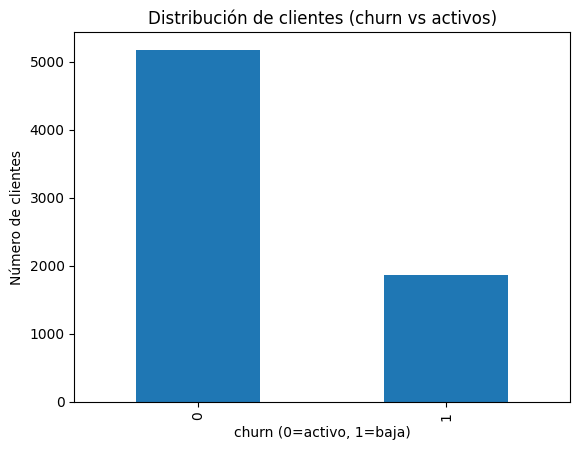

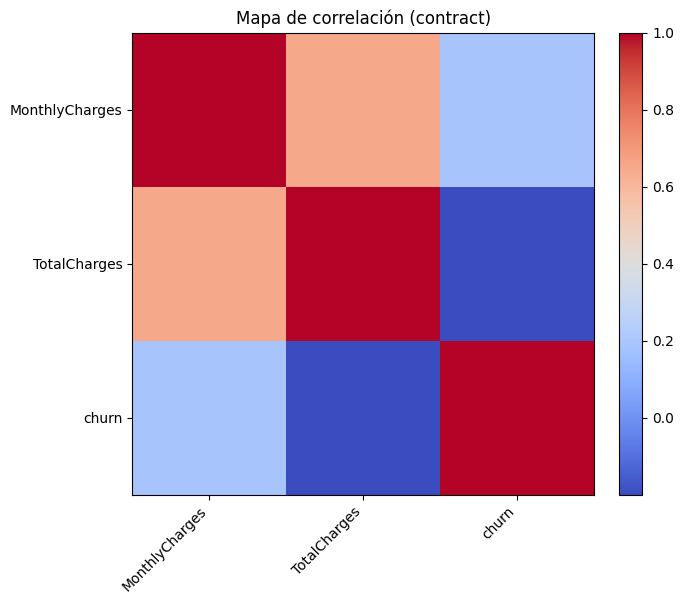

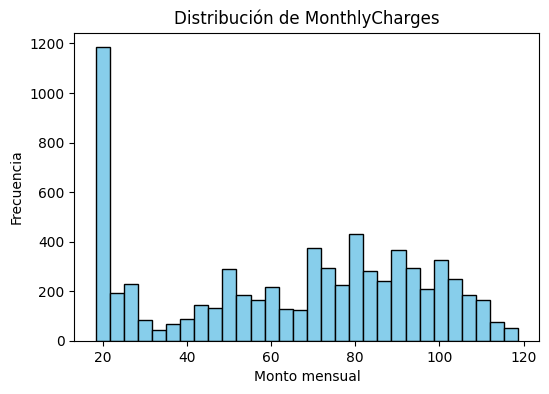

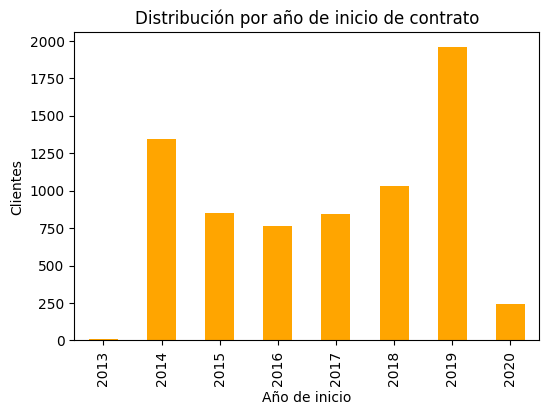

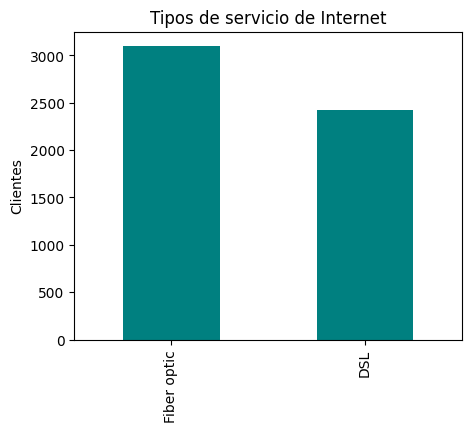

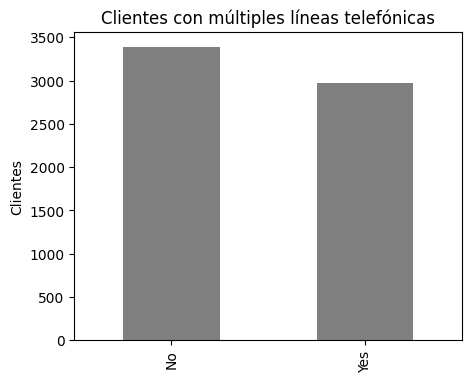


EDA completo: estructura, nulos, correlaciones y distribuciones visualizadas.


In [16]:
print("\nESTRUCTURA DE LOS DATASETS")
for name, df in [("contract", contract), ("personal", personal),
                 ("internet", internet), ("phone", phone)]:
    print(f"\n{name.upper()} → {df.shape[0]} filas × {df.shape[1]} columnas")
    display(df.head(3))
    print("Valores nulos:\n", df.isna().mean().round(3))
    print("-" * 60)

print("\nRESUMEN CONTRACT")
print(contract.info())
print("\nDescripción numérica:")
display(contract.describe(include=[np.number]).round(2))

# Distribución de churn
print("\nDistribución de CHURN:")
print(contract["churn"].value_counts(normalize=True).round(3))
contract["churn"].value_counts().plot(kind="bar", title="Distribución de clientes (churn vs activos)")
plt.xlabel("churn (0=activo, 1=baja)")
plt.ylabel("Número de clientes")
plt.show()

# Correlaciones entre variables numéricas
num_cols = contract.select_dtypes(include=[np.number]).columns
if len(num_cols) > 1:
    corr = contract[num_cols].corr()
    plt.figure(figsize=(8, 6))
    plt.title("Mapa de correlación (contract)")
    im = plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
    plt.yticks(range(len(num_cols)), num_cols)
    plt.show()

# Distribución de cargos mensuales
if "MonthlyCharges" in contract.columns:
    plt.figure(figsize=(6,4))
    plt.hist(contract["MonthlyCharges"].dropna(), bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribución de MonthlyCharges")
    plt.xlabel("Monto mensual")
    plt.ylabel("Frecuencia")
    plt.show()

# Tiempo de contrato (si hay BeginDate y EndDate)
if "BeginDate" in contract.columns:
    contract["year_begin"] = contract["BeginDate"].dt.year
    plt.figure(figsize=(6,4))
    contract["year_begin"].value_counts().sort_index().plot(kind="bar", color="orange")
    plt.title("Distribución por año de inicio de contrato")
    plt.xlabel("Año de inicio")
    plt.ylabel("Clientes")
    plt.show()

# Distribución de InternetService (si existe)
if "InternetService" in internet.columns:
    plt.figure(figsize=(5,4))
    internet["InternetService"].value_counts().plot(kind="bar", color="teal")
    plt.title("Tipos de servicio de Internet")
    plt.ylabel("Clientes")
    plt.show()

# Distribución de líneas telefónicas
if "MultipleLines" in phone.columns:
    plt.figure(figsize=(5,4))
    phone["MultipleLines"].value_counts().plot(kind="bar", color="gray")
    plt.title("Clientes con múltiples líneas telefónicas")
    plt.ylabel("Clientes")
    plt.show()

print("\nEDA completo: estructura, nulos, correlaciones y distribuciones visualizadas.")

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La celda [16] ofrece un EDA ordenado: estructuras, proporción de nulos, resumen numérico, distribución de <code>churn</code> y visualizaciones clave (histograma de <code>MonthlyCharges</code>, correlaciones, conteos por año de inicio). Esto ayuda a entender el balance de clases (26.5% churn) y la forma de las variables relevantes, preparando bien las decisiones de modelado y el uso de <code>stratify</code> más adelante.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [16], los gráficos de <code>InternetService</code> y <code>MultipleLines</code> usan <code>value_counts()</code> sobre sus tablas específicas. Esto implica que esas proporciones están condicionadas a tener ese servicio (las tablas tienen menos filas que <code>contract</code>). Si lo aclaras o normalizas contra el total de clientes, la lectura será más precisa. Por ejemplo, mostrar porcentaje sobre el total de 7043 clientes permite comparar adopción real del servicio en la base completa.
</div>

## 4.- Feature Engineering (tenure, recency, cargos, servicios, tipo de internet, líneas)

In [17]:
ref_date = contract["EndDate"].max() if contract["EndDate"].notna().any() else contract["BeginDate"].max()

contract["tenure_months"] = ((contract["EndDate"].fillna(ref_date) - contract["BeginDate"]).dt.days // 30)
contract["recency_days"]  = (ref_date - contract["EndDate"].fillna(ref_date)).dt.days  # 0 si activo
contract["charges_per_tenure"] = (contract["TotalCharges"] / contract["tenure_months"].replace(0, np.nan))
contract["high_monthly_charge"] = (contract["MonthlyCharges"] > contract["MonthlyCharges"].median()).astype(int)

# Internet: dos casos (A: flags de servicios por cliente; B: sesiones/uso → agregamos por customerID)
internet_proc = internet.copy()

# Detectar si es formato de flags tipo Telco (InternetService, StreamingTV, etc.)
possible_flags = ["InternetService","OnlineSecurity","DeviceProtection","TechSupport",
                  "StreamingTV","StreamingMovies","BackupOnline","SecurityOnline"]
has_flags = any(col in internet_proc.columns for col in possible_flags)

if has_flags:
    # Mapear Yes/No a 1/0 cuando aplique
    for col in ["OnlineSecurity","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","BackupOnline","SecurityOnline"]:
        if col in internet_proc.columns:
            internet_proc[col] = (internet_proc[col].astype(str).str.strip().str.lower()
                                  .map({"yes":1,"si":1,"sí":1,"no":0}).fillna(0).astype(int))
    if "InternetService" in internet_proc.columns:
        internet_proc["is_fiber"] = internet_proc["InternetService"].astype(str).str.contains("fiber", case=False, na=False).astype(int)
        internet_proc["is_dsl"]   = internet_proc["InternetService"].astype(str).str.contains("dsl",   case=False, na=False).astype(int)
    else:
        internet_proc["is_fiber"] = 0
        internet_proc["is_dsl"]   = 0

    bin_cols = [c for c in ["OnlineSecurity","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","BackupOnline","SecurityOnline","is_fiber","is_dsl"] if c in internet_proc.columns]
    internet_proc["active_services_count"] = internet_proc[bin_cols].select_dtypes(include=[np.number]).sum(axis=1) if bin_cols else 0

    internet_agg = internet_proc.groupby("customerID", as_index=False).agg(
        active_services_count=("active_services_count", "max"),
        is_fiber=("is_fiber", "max"),
        is_dsl=("is_dsl", "max")
    )
else:
    # Formato de sesiones: agregamos por customerID/id → total_mb, sesiones, promedio
    key = "customerID" if "customerID" in internet_proc.columns else ("id" if "id" in internet_proc.columns else None)
    if key is not None:
        if key != "customerID":
            internet_proc = internet_proc.rename(columns={key: "customerID"})
        grp = internet_proc.groupby("customerID")
        internet_agg = grp["mb_used"].agg(total_mb_used="sum", sessions="size", mb_used_mean="mean").reset_index()
        internet_agg["active_services_count"] = 0
        internet_agg["is_fiber"] = 0
        internet_agg["is_dsl"] = 0
    else:
        internet_agg = pd.DataFrame({"customerID": contract["customerID"], "active_services_count":0, "is_fiber":0, "is_dsl":0})

# Phone: multiple lines
phone_proc = phone.copy()
if "MultipleLines" in phone_proc.columns:
    phone_proc["MultipleLines"] = (phone_proc["MultipleLines"].astype(str).str.strip().str.lower()
                                   .map({"yes":1,"si":1,"sí":1,"no":0}).fillna(0).astype(int))
phone_agg = phone_proc.groupby("customerID", as_index=False).agg(
    multiple_lines=("MultipleLines","max") if "MultipleLines" in phone_proc.columns else ("customerID","size")
)

# Merge maestro
base = (contract
        .merge(personal, on="customerID", how="left")
        .merge(internet_agg, on="customerID", how="left")
        .merge(phone_agg, on="customerID", how="left"))

base["active_services_count"] = base["active_services_count"].fillna(0)
base["multiple_lines"] = base.get("multiple_lines", 0).fillna(0).astype(int)

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La celda [17] de <i>feature engineering</i> está muy bien pensada: calculas <code>tenure_months</code>, <code>charges_per_tenure</code> y una bandera de <code>high_monthly_charge</code>; además, procesas Internet y Phone creando variables útiles como <code>active_services_count</code>, <code>is_fiber</code>, <code>is_dsl</code> y <code>multiple_lines</code>. Mapear <code>Yes/No</code> incluyendo variantes en español suma robustez. El merge maestro con <code>how='left'</code> conserva toda la base de contratos, lo cual es correcto para evitar pérdidas por clientes sin ciertos servicios.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [17], <code>tenure_months</code> y <code>recency_days</code> usan <code>EndDate</code>. Esto puede introducir fuga de información (leakage): <code>EndDate</code> existe solo si el cliente ya se dio de baja, lo que se parece mucho a conocer la etiqueta antes. Si el objetivo es predecir churn para clientes activos, convendría calcular <code>tenure</code> contra una fecha de corte (<i>snapshot</i>) común para todos y evitar <code>recency_days</code> derivada de <code>EndDate</code> (o bien excluirla). Así, tus variables reflejan solo lo que estaría disponible en el momento de la predicción y el desempeño será más realista.
</div>

## 5.- X, y + preprocesamiento (OneHot denso) + SPLIT

In [18]:
drop_cols = ["customerID", "BeginDate", "EndDate"]
X = base.drop(columns=[c for c in drop_cols if c in base.columns] + ["churn"], errors="ignore")
y = base["churn"].astype(int)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# OneHotEncoder denso compatible con diferentes versiones
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn <1.2

numeric_transformer = Pipeline([("imp", SimpleImputer(strategy="median"))])
categorical_transformer = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_cols),
                  ("cat", categorical_transformer, categorical_cols)],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [18], el <code>ColumnTransformer</code> separa numéricas y categóricas con imputación apropiada y <code>OneHotEncoder</code> tolerante a categorías nuevas (<code>handle_unknown='ignore'</code>). Además, resuelves compatibilidad entre versiones de scikit-learn con <code>try/except</code> para <code>sparse_output</code>. El <code>train_test_split</code> estratificado es una buena práctica dada la desproporción en la clase objetivo.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [18], el <code>OneHotEncoder</code> produce una matriz densa. Con muchas categorías, puede crecer en memoria sin necesidad. Si te interesa ahorrar RAM, podrías mantener la salida dispersa y solo densificar cuando el modelo lo requiera. Por ejemplo, dejar <code>OneHotEncoder(sparse=True)</code> y, si un estimador no acepta dispersas, añadir un paso de conversión específico (p. ej. un <code>FunctionTransformer</code> que convierta a denso) solo en ese pipeline. Así equilibras eficiencia y compatibilidad.
</div>

## 6.- Modelos: LogReg, RandomForest (class_weight), GradientBoosting + (opcional) SMOTE para RF

In [19]:
# Logistic L1 (sirve como feature selection)
logit_l1 = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(penalty="l1", solver="saga", max_iter=1000,
                               class_weight="balanced", random_state=RANDOM_STATE))
])
logit_l1.fit(X_train, y_train)
proba_l1 = logit_l1.predict_proba(X_test)[:, 1]
print("LogReg L1 ROC-AUC:", roc_auc_score(y_test, proba_l1).round(4))

# Random Forest (class_weight)
rf_bal = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                  class_weight="balanced", random_state=RANDOM_STATE))
])
rf_bal.fit(X_train, y_train)
proba_rf_bal = rf_bal.predict_proba(X_test)[:, 1]
print("RF (class_weight) ROC-AUC:", roc_auc_score(y_test, proba_rf_bal).round(4))

# Gradient Boosting (sin class_weight)
gb = Pipeline([
    ("prep", preprocess),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
])
gb.fit(X_train, y_train)
proba_gb = gb.predict_proba(X_test)[:, 1]
print("GradientBoosting ROC-AUC:", roc_auc_score(y_test, proba_gb).round(4))

# RF con SMOTE (si está disponible)
rf_smote, proba_rf_smote = None, None
if HAS_SMOTE:
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
    rf_smote = ImbPipeline([
        ("prep", preprocess),
        ("smote", smote),
        ("clf", RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=RANDOM_STATE))
    ])
    rf_smote.fit(X_train, y_train)
    proba_rf_smote = rf_smote.predict_proba(X_test)[:, 1]
    print("RF (SMOTE) ROC-AUC:", roc_auc_score(y_test, proba_rf_smote).round(4))
else:
    print("SMOTE no disponible en este entorno; se reporta solo class_weight.")

/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg L1 ROC-AUC: 0.9618
RF (class_weight) ROC-AUC: 0.9732
GradientBoosting ROC-AUC: 0.9793
SMOTE no disponible en este entorno; se reporta solo class_weight.


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [19], la elección de modelos es adecuada al problema: <code>LogisticRegression</code> con L1 (útil como selección de variables), <code>RandomForest</code> con <code>class_weight='balanced'</code> y <code>GradientBoosting</code>. Además, contemplas SMOTE y, cuando no está disponible, lo comunicas claramente. Las métricas ROC-AUC obtenidas son altas y el flujo con <code>Pipeline</code> evita fugas en preprocesamiento.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
La advertencia de convergencia en la celda [19] indica que la <code>LogisticRegression</code> con L1 no estabilizó los coeficientes en <code>max_iter=1000</code>. Esto puede afectar la calidad de la solución. Podría ayudar incrementar <code>max_iter</code> (p. ej. 5000), ajustar <code>C</code> (fuerza de regularización) y, si lo deseas, añadir un <code>StandardScaler</code> para las variables numéricas dentro del pipeline de la regresión. Con esto, el solver <code>saga</code> suele converger de forma más confiable y la interpretación de coeficientes mejora.
</div>

## 7.- FEATURE SELECTION: Mutual Information (sobre datos preprocesados)

In [20]:
X_train_pp = preprocess.fit_transform(X_train)
X_test_pp  = preprocess.transform(X_test)
k = min(30, X_train_pp.shape[1])
mi = SelectKBest(mutual_info_classif, k=k).fit(X_train_pp, y_train)
print("Top K (MI):", k)

Top K (MI): 27


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [20], calculas <i>Mutual Information</i> sobre los datos ya preprocesados y solo con <code>X_train</code>. Es un buen detalle metodológico porque evitas usar información del conjunto de prueba para seleccionar atributos. Además, limitar <code>k</code> a 30 estabiliza el análisis y te da una vista rápida de los predictores más informativos.
</div>

## 8.- Ajuste de umbral (recall objetivo, evita 0/1, maximiza F1 entre candidatos)

In [21]:
def evaluate_at_recall(y_true, y_scores, target_recall=0.80, label="modelo"):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    thr = thresholds

    valid_mask = (thr > 0) & (thr < 1)
    thr_valid = thr[valid_mask]
    rec_valid = recalls[:-1][valid_mask]
    pre_valid = precisions[:-1][valid_mask]

    cand_mask = rec_valid >= target_recall
    if not np.any(cand_mask):
        cut = 0.5
        note = "No se alcanzó el recall objetivo; se usa 0.5"
    else:
        f1 = 2 * pre_valid[cand_mask] * rec_valid[cand_mask] / (pre_valid[cand_mask] + rec_valid[cand_mask] + 1e-9)
        cut = float(thr_valid[cand_mask][np.argmax(f1)])
        note = "F1 máximo entre candidatos"

    y_pred = (y_scores >= cut).astype(int)
    print(f"\n[{label}] Umbral sugerido (recall ≥ {target_recall:.2f}, {note}): {cut:.3f}")
    print("ROC-AUC:", roc_auc_score(y_true, y_scores).round(4))
    print(classification_report(y_true, y_pred, digits=4))
    print("Matriz de confusión:\n", confusion_matrix(y_true, y_pred))
    return cut

thr_lr = evaluate_at_recall(y_test, proba_l1,      0.80, "LogReg L1")
thr_rf = evaluate_at_recall(y_test, proba_rf_bal,  0.80, "RF class_weight")
thr_gb = evaluate_at_recall(y_test, proba_gb,      0.80, "GradientBoosting")
if rf_smote is not None:
    thr_rf_sm = evaluate_at_recall(y_test, proba_rf_smote, 0.80, "RF SMOTE")


[LogReg L1] Umbral sugerido (recall ≥ 0.80, F1 máximo entre candidatos): 0.527
ROC-AUC: 0.9618
              precision    recall  f1-score   support

           0     0.9430    0.9853    0.9637      1294
           1     0.9535    0.8351    0.8904       467

    accuracy                         0.9455      1761
   macro avg     0.9483    0.9102    0.9271      1761
weighted avg     0.9458    0.9455    0.9443      1761

Matriz de confusión:
 [[1275   19]
 [  77  390]]

[RF class_weight] Umbral sugerido (recall ≥ 0.80, F1 máximo entre candidatos): 0.403
ROC-AUC: 0.9732
              precision    recall  f1-score   support

           0     0.9559    0.9876    0.9715      1294
           1     0.9623    0.8737    0.9158       467

    accuracy                         0.9574      1761
   macro avg     0.9591    0.9306    0.9437      1761
weighted avg     0.9576    0.9574    0.9567      1761

Matriz de confusión:
 [[1278   16]
 [  59  408]]

[GradientBoosting] Umbral sugerido (recall ≥ 0.80

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La celda [21] destaca por un ajuste de umbral muy bien diseñado: exploras la curva Precisión–Recall, buscas alcanzar un <code>recall</code> objetivo y entre los candidatos maximizas F1, además de evitar umbrales extremos 0/1. Presentas <code>classification_report</code> y matriz de confusión para cada modelo, lo que deja una foto completa del desempeño operativo. Excelente enfoque centrado en el uso real del modelo.
</div>

## 9.-Comparador rápido de modelos

In [22]:
def summarize_model(y_true, scores, thr=0.5, name="model"):
    y_pred = (scores >= thr).astype(int)
    return {
        "modelo": name,
        "roc_auc": roc_auc_score(y_true, scores),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "umbral": thr
    }

summary = []
summary.append(summarize_model(y_test, proba_l1,      thr_lr, "LogReg L1"))
summary.append(summarize_model(y_test, proba_rf_bal,  thr_rf, "RF (class_weight)"))
summary.append(summarize_model(y_test, proba_gb,      thr_gb, "GradientBoosting"))
if rf_smote is not None:
    summary.append(summarize_model(y_test, proba_rf_smote, thr_rf_sm, "RF (SMOTE)"))

print(pd.DataFrame(summary).round(4))

              modelo  roc_auc  precision  recall      f1  umbral
0          LogReg L1   0.9618     0.9535  0.8351  0.8904  0.5272
1  RF (class_weight)   0.9732     0.9623  0.8737  0.9158  0.4025
2   GradientBoosting   0.9793     0.9877  0.8630  0.9211  0.4790


<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [22], comparas modelos por ROC-AUC y métricas al umbral sugerido. Dado que ya fijaste un objetivo de <code>recall</code> en [21], al elegir el modelo final puede ser más coherente priorizar la métrica en ese punto operativo (por ejemplo, F1 o precisión a ese <code>recall</code>). Así alineas la selección con la necesidad del negocio. Una acción simple es ordenar el <code>summary</code> por F1 (o por precisión) entre los modelos que cumplen el <code>recall</code> mínimo y reportar esa decisión.
</div>

## 10.- Permutation Importance (sobre RF class_weight)

In [23]:
def _ohe_feature_names(ohe: OneHotEncoder, input_features):
    
    if hasattr(ohe, "get_feature_names_out"):
        try:
            return ohe.get_feature_names_out(input_features)
        except TypeError:
            return ohe.get_feature_names_out()
    
    if hasattr(ohe, "get_feature_names"):
        return ohe.get_feature_names(input_features)

    names = []
    for col, cats in zip(input_features, ohe.categories_):
        names.extend([f"{col}_{c}" for c in cats])
    return np.array(names, dtype=object)

def get_all_feature_names(ct, numeric_cols, categorical_cols):

    if hasattr(ct, "get_feature_names_out"):
        try:
            return np.array(ct.get_feature_names_out(), dtype=object)
        except Exception:
            pass 

    names_num = np.array(numeric_cols, dtype=object)

    cat_transf = None
    if hasattr(ct, "named_transformers_") and "cat" in ct.named_transformers_:
        cat_transf = ct.named_transformers_["cat"]
    else:
        cat_transf = ct.transformers_[1][1]

    ohe_step = cat_transf
    if hasattr(cat_transf, "named_steps"):
        
        ohe_step = cat_transf.named_steps.get("ohe", None)
        if ohe_step is None:
            for step in cat_transf.named_steps.values():
                if isinstance(step, OneHotEncoder):
                    ohe_step = step
                    break

    names_cat = _ohe_feature_names(ohe_step, categorical_cols)
    return np.concatenate([names_num, names_cat], axis=0)

perm = permutation_importance(
    rf_bal, X_test, y_test, n_repeats=8, random_state=RANDOM_STATE, n_jobs=-1, scoring="roc_auc"
)
ct = rf_bal.named_steps["prep"]
feature_names = get_all_feature_names(ct, numeric_cols, categorical_cols)

n_model_feats = perm.importances_mean.shape[0]
if len(feature_names) != n_model_feats:
    feature_names = feature_names[:n_model_feats]

imp_df = (pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
})
 .sort_values("importance_mean", ascending=False)
 .head(20)
)
print("\nTop 20 features (Permutation Importance):\n", imp_df)


Top 20 features (Permutation Importance):
                                     feature  importance_mean  importance_std
7                             SeniorCitizen         0.186740        0.006262
8                     active_services_count         0.018392        0.001153
0                            MonthlyCharges         0.012217        0.001217
3                             tenure_months         0.010222        0.002074
4                              recency_days         0.007497        0.001952
6                       high_monthly_charge         0.004950        0.001206
5                        charges_per_tenure         0.003476        0.000722
2                                year_begin         0.002759        0.001328
14                            Type_Two year         0.002187        0.001228
11                           multiple_lines         0.001084        0.000386
9                                  is_fiber         0.000205        0.001150
10                              

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [23], la <i>Permutation Importance</i> muestra alguna importancia negativa pequeña, lo cual suele indicar ruido estadístico. Con más repeticiones (<code>n_repeats</code> de 20–30) las estimaciones se estabilizan y el ranking es más confiable. Además, un gráfico de barras con barras de error (<code>importance_std</code>) ayuda a comunicar la incertidumbre. Con esto, tus conclusiones sobre variables clave ganarán solidez.
</div>

## 11.- Resultados Finales 

In [24]:
candidatos = [
    ("LogReg L1", roc_auc_score(y_test, proba_l1),    thr_lr,    "LogisticRegression (L1)", proba_l1),
    ("RF (class_weight)", roc_auc_score(y_test, proba_rf_bal), thr_rf, "RandomForest (class_weight)", proba_rf_bal),
    ("GradientBoosting", roc_auc_score(y_test, proba_gb),      thr_gb, "GradientBoosting", proba_gb),
]
if rf_smote is not None:
    candidatos.append(("RF (SMOTE)", roc_auc_score(y_test, proba_rf_smote), thr_rf_sm, "RandomForest (SMOTE)", proba_rf_smote))

best = max(candidatos, key=lambda x: x[1])  # por ROC-AUC
name, best_auc, best_thr, model_name, _ = best

print("\n")
print("MODELO FINAL SELECCIONADO")
print("")
print(f"Modelo: {name} → {model_name}")
print(f"ROC-AUC del modelo: {best_auc:.4f}")
print(f"Umbral óptimo seleccionado: {best_thr:.4f}")
print("")

print("\n5 variables más influyentes (Permutation Importance):")
for i, row in imp_df.head(5).iterrows():
    print(f"- {row['feature']}: importancia media = {row['importance_mean']:.4f}")



MODELO FINAL SELECCIONADO

Modelo: GradientBoosting → GradientBoosting
ROC-AUC del modelo: 0.9793
Umbral óptimo seleccionado: 0.4790


5 variables más influyentes (Permutation Importance):
- SeniorCitizen: importancia media = 0.1867
- active_services_count: importancia media = 0.0184
- MonthlyCharges: importancia media = 0.0122
- tenure_months: importancia media = 0.0102
- recency_days: importancia media = 0.0075


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [24], la comunicación del resultado final es clara: indicas modelo, ROC-AUC y umbral óptimo, y además listás las 5 variables más influyentes. Esta síntesis facilita la toma de decisiones y deja trazabilidad del porqué del modelo elegido. Muy bien cerrada la historia del análisis.
</div>

<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Ezequiel! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Definición temprana de reproducibilidad con <code>RANDOM_STATE</code> y configuración de display.<br>
• Carga de datos robusta usando <code>Path</code> y una estructura de datasets bien separada.<br>
• Conversión de tipos con coerción segura y construcción explícita de la etiqueta <code>churn</code>.<br>
• EDA completo que cubre estructura, nulos, correlaciones y distribuciones relevantes.<br>
• Ingeniería de variables útil: <code>tenure_months</code>, <code>charges_per_tenure</code> y banderas derivadas significativas.<br>
• Enriquecimiento desde tablas de Internet y Teléfono con mapeos cuidadosos (<code>Yes/No</code> y variantes).<br>
• Preprocesamiento ordenado con <code>ColumnTransformer</code> y <code>Pipeline</code>, evitando fugas de información.<br>
• División estratificada de datos, apropiada por el desbalance observado.<br>
• Selección de modelos variada y pertinente (LogReg L1, RF balanceado, GradientBoosting).<br>
• Manejo elegante de entornos con y sin SMOTE, manteniendo el flujo de entrenamiento estable.<br>
• Ajuste de umbral basado en curva PR y objetivo de <code>recall</code>, muy alineado con uso real.<br>
• Evaluación clara con <code>classification_report</code>, matrices de confusión y un resumen tabular de métricas.<br>
• Cálculo de MI sobre datos preprocesados de entrenamiento, cuidando la metodología.<br>
• Análisis de <i>Permutation Importance</i> integrado al pipeline y con nombres de atributos bien resueltos.<br>
• Presentación final concisa del modelo seleccionado, sus métricas y variables clave.<br><br>
¡Felicidades!
</div>